In [80]:
# from gmn_lim.graph_construct.model_arch_graph import seq_to_feats, sequential_to_arch, arch_to_graph, graph_to_arch, arch_to_sequential
from gmn_lim.graph_models import EdgeMPNNDiT
from gmn_lim.feature_extractor_gmn import GraphPredGen
from torchviz import make_dot
import torch
import torch.nn as nn
from torch.func import functional_call
import json
import math
import time
import os
import sys
from gmn_lim.graph_construct.constants import NODE_TYPES, EDGE_TYPES, CONV_LAYERS, NORM_LAYERS, RESIDUAL_LAYERS, NODE_TYPE_TO_LAYER
from gmn_lim.graph_construct.utils import (
    make_node_feat,
    make_edge_attr,
    conv_to_graph,
    linear_to_graph,
    norm_to_graph,
    ffn_to_graph,
    basic_block_to_graph,
    self_attention_to_graph,
    equiv_set_linear_to_graph,
    triplanar_to_graph,
)
from gmn_lim.graph_construct.model_arch_graph import (
    seq_to_feats,
    sequential_to_arch,
    arch_to_graph,
    graph_to_arch,
    arch_to_named_params

)
from gmn_lim.graph_construct.layers import (
    Flatten,
    PositionwiseFeedForward,
    BasicBlock,
    SelfAttention,
    EquivSetLinear,
    TriplanarGrid,
)
from experiments.gmn_dev.config import Config

In [12]:
config = Config()

In [82]:
from experiments.gmn_dev.optimizees import MLP
from experiments.gmn_dev.tasks import QuadraticTask, MNISTTask


mlp = MLP(input_size = config.downsample_size**2, hidden_sizes=[64, 64], output_size=10)
mlp = mlp.to(config.device)
train_task = MNISTTask(config=config, train=True)
test_task = MNISTTask(config=config, train=False)



In [62]:
def generate_weights(nn_module):
    """
    Generates weights for a given nn.Module.
    """
    weights = {}
    for name, param in nn_module.named_parameters():
        if param.requires_grad:
            # Generate random weights for the parameter
            if len(param.shape) == 1:
                weights[name] = torch.randn(param.shape)
            else:
                weights[name] = param.detach().clone()
                torch.nn.init.xavier_uniform_(weights[name])
    return weights
sample_weights = [generate_weights(mlp) for _ in range(4)]

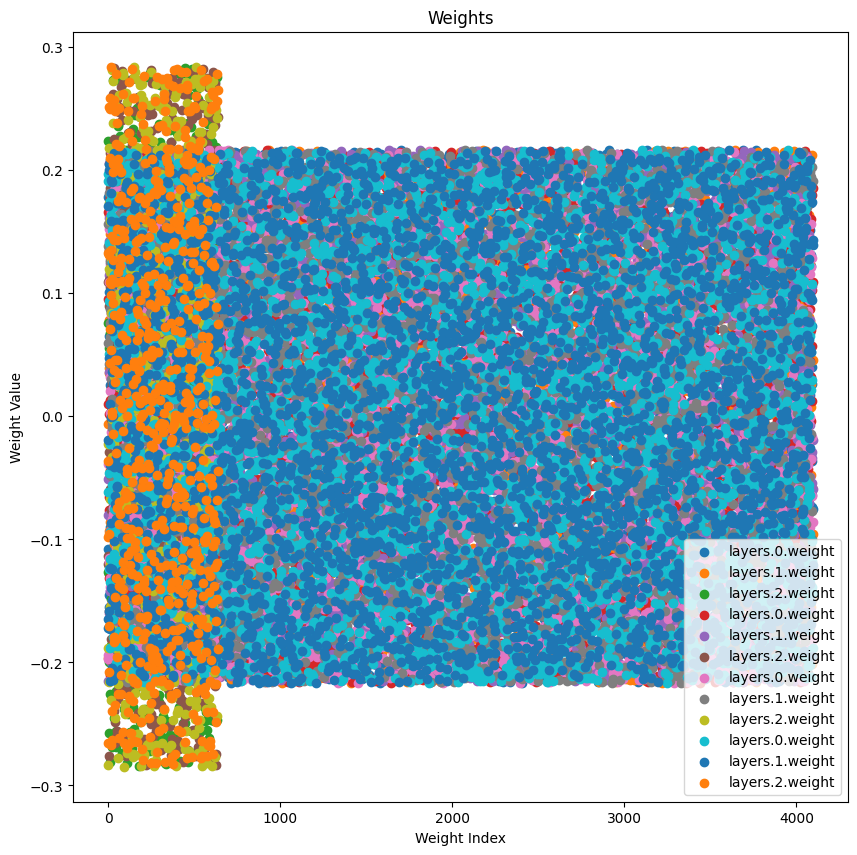

In [63]:
import matplotlib.pyplot as plt
import numpy as np


# plot weights
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i, weights in enumerate(sample_weights):
    for name, param in weights.items():
        if 'weight' in name:
            ax.scatter(np.arange(len(param.flatten())), param.flatten().cpu().numpy(), label=name)
ax.set_title('Weights')
ax.set_xlabel('Weight Index')
ax.set_ylabel('Weight Value')
ax.legend()
plt.show()

In [69]:
def train(task, model, epochs=1000, lr=1e-3, params = None):
    """
    Trains a model on a task for a given number of iterations.
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    dataloader = task.dataloader
    model.train()
    if params is not None:
        # set the model parameters to the given params
        for name, param in model.named_parameters():
            if name in params:
                param.data = params[name].data
    model.to(config.device)
    
    for i in range(epochs):
        train_loss = 0
        for j, batch in enumerate(dataloader):
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(config.device)
            targets = targets.to(config.device)
            out = model(inputs)
            loss = task.loss(out, targets)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        if i % 10 == 0:
            print(f"Epoch {i}: Loss = {train_loss / len(dataloader)}")  
    # return new params
    return {name: param for name, param in model.named_parameters()}
def test(task, model, params = None):
    """
    Tests a model on a task.
    """
    dataloader = task.dataloader
    total_loss = 0
    model.eval()
    if params is not None:
        # set the model parameters to the given params
        for name, param in model.named_parameters():
            if name in params:
                param.data = params[name].data
    model.to(config.device)
    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch 
            inputs = inputs.to(config.device)
            targets = targets.to(config.device)
            out = model(inputs)
            loss = task.loss(out, targets)
            total_loss += loss.item()
    return total_loss / len(dataloader)

trained_params = train(train_task, mlp, epochs=1)
test(test_task, mlp, params=trained_params)

Epoch 0: Loss = 0.7210390913461063


0.3226472375136388

In [67]:
results = []
for i in range(10):
    random_weights = generate_weights(mlp)
    best_loss = float('inf')
    best_weights = None
    lr_samples = [1e-5, 1e-4, 1e-3, 1e-2]
    for lr in lr_samples:
        print(f"Testing lr {lr}")
        mlp = mlp.to(config.device)
        trained_params = train(train_task, mlp, epochs=20, lr=lr, params=random_weights)
        loss = test(test_task, mlp, params=trained_params)
        print(f"Loss: {loss}")

        if loss < best_loss:
            best_loss = loss
            best_weights = trained_params
    results.append((best_loss, best_weights))

Testing lr 1e-05


KeyboardInterrupt: 

In [71]:
num_params = sum([param.numel() for param in mlp.parameters()])
print(f"Number of parameters: {num_params}")

Number of parameters: 8970


In [73]:
losses = []
weights = []
for i in range(100):
    rand_weights = generate_weights(mlp)
    mlp = mlp.to(config.device)

    test_loss = test(test_task, mlp, params=rand_weights)
    print(f"Random model {i}: Loss = {test_loss}")
    losses.append(test_loss)
    weights.append(rand_weights)

    # train for 1 epoch
    trained_params = train(train_task, mlp, epochs=1, params=rand_weights)
    test_loss = test(test_task, mlp, params=trained_params)
    print(f"Trained model {i}: Loss = {test_loss}")
    losses.append(test_loss)
    weights.append(trained_params)

Random model 0: Loss = 3.992836161504818
Epoch 0: Loss = 0.7053414037042081
Trained model 0: Loss = 0.31274792193611967
Random model 1: Loss = 2.946128981022895
Epoch 0: Loss = 0.6289418965323902
Trained model 1: Loss = 0.27881355677978903
Random model 2: Loss = 3.3610154646861403
Epoch 0: Loss = 0.6810759607789867
Trained model 2: Loss = 0.3061470423318163
Random model 3: Loss = 3.591517098342316
Epoch 0: Loss = 0.6977303810655944
Trained model 3: Loss = 0.3159053653855867
Random model 4: Loss = 3.572130529186394
Epoch 0: Loss = 0.7043688654391242
Trained model 4: Loss = 0.303428272280512
Random model 5: Loss = 3.7371103431605084
Epoch 0: Loss = 0.7079050536475965
Trained model 5: Loss = 0.3135560004017021
Random model 6: Loss = 2.883146455016317
Epoch 0: Loss = 0.668764689869718
Trained model 6: Loss = 0.300423767559136
Random model 7: Loss = 2.6319850155069857
Epoch 0: Loss = 0.6561300814914297
Trained model 7: Loss = 0.3139622688670702
Random model 8: Loss = 3.5458649623243113
Epoc

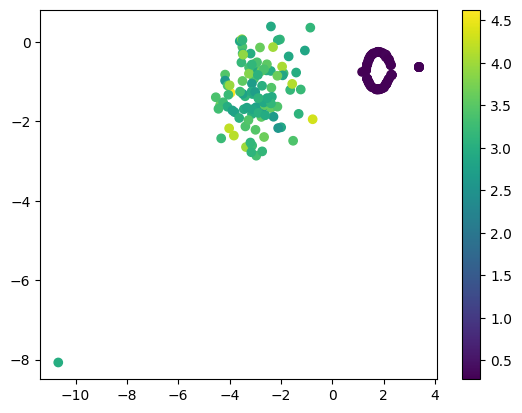

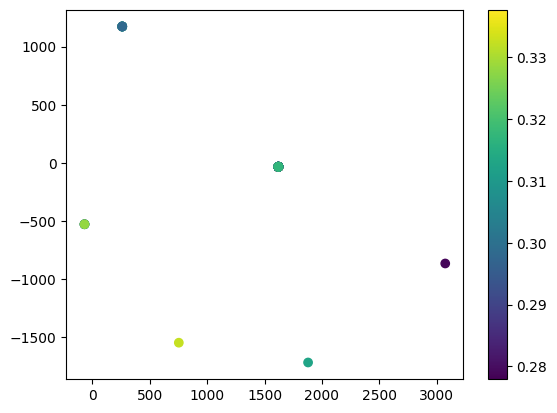

100

In [78]:
## tsne
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# tsne on model weights vs loss
def plot_tsne(losses, weights):
    weights = np.array(weights)
    tsne = TSNE(n_components=2, random_state=0)
    X_embedded = tsne.fit_transform(weights)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=losses)
    plt.colorbar()
    plt.show()
weights_list = []
for i in range(len(weights)):
    lst = []
    for name, param in weights[i].items():
        lst.extend(param.flatten().cpu().detach().numpy())
    weights_list.append(lst)
plot_tsne(losses, weights_list)

trained_list = []
for i in range(1, len(weights), 2):
    lst = []
    for name, param in weights[i].items():
        lst.extend(param.flatten().cpu().detach().numpy())
    trained_list.append(lst)
plot_tsne(losses[1::2], trained_list)
# plot the loss vs the weights

len(trained_list)
